# CoG paper experiments

In [1]:
from pcgsepy.setup_utils import setup_matplotlib, get_default_lsystem

setup_matplotlib(larger_fonts=False)

used_ll_blocks = [
    'MyObjectBuilder_CubeBlock_LargeBlockArmorCornerInv',
    'MyObjectBuilder_CubeBlock_LargeBlockArmorCorner',
    'MyObjectBuilder_CubeBlock_LargeBlockArmorSlope',
    'MyObjectBuilder_CubeBlock_LargeBlockArmorBlock',
    'MyObjectBuilder_Gyro_LargeBlockGyro',
    'MyObjectBuilder_Reactor_LargeBlockSmallGenerator',
    'MyObjectBuilder_CargoContainer_LargeBlockSmallContainer',
    'MyObjectBuilder_Cockpit_OpenCockpitLarge',
    'MyObjectBuilder_Thrust_LargeBlockSmallThrust',
    'MyObjectBuilder_InteriorLight_SmallLight',
    'MyObjectBuilder_CubeBlock_Window1x1Slope',
    'MyObjectBuilder_CubeBlock_Window1x1Flat',
    'MyObjectBuilder_InteriorLight_LargeBlockLight_1corner'
]

lsystem = get_default_lsystem(used_ll_blocks=used_ll_blocks)

## Experiment 1

Run standard FI-2Pop against variant FI-2Pop

### FI-2Pop variant

In [2]:
from typing import Any, Dict, List, Tuple, Optional

import torch as th
import numpy as np
from tqdm.notebook import trange

from pcgsepy.config import N_GENS, N_ITERATIONS, N_RETRIES, POP_SIZE, EPSILON_F
from pcgsepy.evo.fitness import Fitness
from pcgsepy.lsystem.constraints import ConstraintLevel
from pcgsepy.lsystem.lsystem import LSystem
from pcgsepy.lsystem.solution import CandidateSolution
from pcgsepy.fi2pop.utils import create_new_pool, reduce_population, subdivide_solutions

from pcgsepy.fi2pop.utils import MLPEstimator, prepare_dataset, train_estimator
from pcgsepy.mapelites.buffer import Buffer, EmptyBufferException

class FI2PopVariantSolver:
    def __init__(self,
                 feasible_fitnesses: List[Fitness],
                 lsystem: LSystem,
                 buffer: Buffer,
                 estimator: Optional[MLPEstimator] = None):
        """Create the FI2Pop solver.

        Args:
            feasible_fitnesses (List[Fitness]): The list of fitnesses.
            lsystem (LSystem): The L-system object.
        """
        self.feasible_fitnesses = feasible_fitnesses
        self.lsystem = lsystem
        self.ftop = []
        self.itop = []
        self.fmean = []
        self.imean = []

        self.ffs, self.ifs = [], []

        # number of total soft constraints
        self.nsc = [c for c in self.lsystem.all_hl_constraints if c.level == ConstraintLevel.SOFT_CONSTRAINT]
        self.nsc = [c for c in self.lsystem.all_ll_constraints if c.level == ConstraintLevel.SOFT_CONSTRAINT]
        self.nsc = len(self.nsc) * 0.5
        
        self.estimator = estimator
        self.buffer = buffer
        self.max_f_fitness = sum([f.bounds[1] for f in self.feasible_fitnesses])

    def reset(self):
        self.ftop = []
        self.itop = []
        self.fmean = []
        self.imean = []
        self.ffs, self.ifs = [], []
        
        self.estimator = MLPEstimator(len(self.feasible_fitnesses), 1)
        self.buffer = Buffer(merge_method=self.buffer._merge)

    def _compute_fitness(self,
                         cs: CandidateSolution,
                         extra_args: Dict[str, Any]) -> List[float]:
        """Compute the fitness of a single candidate solution.

        Args:
            cs (CandidateSolution): The candidate solution.
            extra_args (Dict[str, Any]): Additional arguments used in the fitness function.

        Returns:
            float: The fitness value.
        """
        if cs.fitness == []:
            fs = [f(cs, extra_args) for f in self.feasible_fitnesses]
            cs.fitness = fs
        if cs.is_feasible:
            return sum(cs.fitness)
        else:
            if self.estimator.is_trained:
                with th.no_grad():
                    return self.estimator(th.tensor(cs.fitness).float()).numpy()[0]
            else:
                return EPSILON_F
                # return np.clip(np.abs(np.random.normal(loc=0., scale=1.)), 0, 1)

    def _generate_initial_populations(self,
                                      pops_size: int = POP_SIZE,
                                      n_retries: int = N_RETRIES) -> Tuple[List[CandidateSolution], List[CandidateSolution]]:
        """Generate the initial populations.

        Args:
            pops_size (int, optional): The size of the population. Defaults to POP_SIZE.
            n_retries (int, optional): The number of retries. Defaults to N_RETRIES.

        Returns:
            Tuple[List[CandidateSolution], List[CandidateSolution]]: The Feasible and Infeasible populations.
        """
        feasible_pop, infeasible_pop = [], []
        self.lsystem.disable_sat_check()
        with trange(n_retries, desc='Initialization ') as iterations:
            for i in iterations:
                solutions = self.lsystem.apply_rules(starting_strings=['head', 'body', 'tail'],
                                                     iterations=[1, N_ITERATIONS, 1],
                                                     create_structures=False,
                                                     make_graph=False)
                subdivide_solutions(lcs=solutions,
                                    lsystem=self.lsystem)
                for cs in solutions:
                    if cs.is_feasible and len(feasible_pop) < pops_size and cs not in feasible_pop:
                        feasible_pop.append(cs)
                        cs.c_fitness = self._compute_fitness(cs=cs,
                                                           extra_args={
                                                               'alphabet': self.lsystem.ll_solver.atoms_alphabet
                                                               }) + (self.nsc - cs.ncv)
                    elif not cs.is_feasible and len(infeasible_pop) < pops_size and cs not in feasible_pop:
                        cs.c_fitness = self._compute_fitness(cs=cs,
                                                             extra_args={
                                                                 'alphabet': self.lsystem.ll_solver.atoms_alphabet
                                                                 })
                        infeasible_pop.append(cs)
                iterations.set_postfix(ordered_dict={'fpop-size': f'{len(feasible_pop)}/{pops_size}',
                                                     'ipop-size': f'{len(infeasible_pop)}/{pops_size}'},
                                       refresh=True)
                if i == n_retries or (len(feasible_pop) == pops_size and len(infeasible_pop) == pops_size):
                    break
        return feasible_pop, infeasible_pop

    def initialize(self,
                   pops_size: int = POP_SIZE,
                   n_retries: int = N_RETRIES) -> Tuple[List[CandidateSolution], List[CandidateSolution]]:
        """Initialize the solver by generating the initial populations.

        Returns:
            Tuple[List[CandidateSolution], List[CandidateSolution]]: The Feasible and Infeasible populations.
        """
        f_pop, i_pop = self._generate_initial_populations(pops_size=pops_size,
                                                          n_retries=n_retries)
        f_fitnesses = [cs.c_fitness for cs in f_pop]
        i_fitnesses = [cs.c_fitness for cs in i_pop]
        self.ftop.append(max(f_fitnesses))
        self.fmean.append(sum(f_fitnesses) / len(f_fitnesses))
        self.itop.append(max(i_fitnesses))
        self.imean.append(sum(i_fitnesses) / len(i_fitnesses))
        self.ffs.append([self.ftop[-1], self.fmean[-1]])
        self.ifs.append([self.itop[-1], self.imean[-1]])
        print(f'Created Feasible population of size {len(f_pop)}: t:{self.ftop[-1]};m:{self.fmean[-1]}')
        print(f'Created Infeasible population of size {len(i_pop)}: t:{self.itop[-1]};m:{self.imean[-1]}')
        return f_pop, i_pop

    def fi2pop(self,
               f_pop: List[CandidateSolution],
               i_pop: List[CandidateSolution],
               n_iter: int = N_GENS) -> Tuple[List[CandidateSolution], List[CandidateSolution]]:
        """Apply the FI2Pop algorithm to the given populations for `n_iter` steps.

        Args:
            f_pop (List[CandidateSolution]): The Feasible population.
            i_pop (List[CandidateSolution]): The Infeasible population.
            n_iter (int, optional): The number of iterations to run for. Defaults to N_GENS.

        Returns:
            Tuple[List[CandidateSolution], List[CandidateSolution]]: The Feasible and the Infeasible populations.
        """
        f_pool = []
        i_pool = []
        with trange(n_iter, desc='Generation ') as gens:
            for gen in gens:
                # place the infeasible population in the infeasible pool
                i_pool.extend(i_pop)
                
                f_pool.extend(f_pop)
                
                # create offsprings from feasible population
                new_pool = create_new_pool(population=f_pop,
                                           generation=gen)
                # if feasible, add to feasible pool
                # if infeasible, add to infeasible pool
                subdivide_solutions(lcs=new_pool,
                                    lsystem=self.lsystem)
                for cs in new_pool:
                    if cs.is_feasible:
                        f_pool.append(cs)
                        cs.ll_string = self.lsystem.hl_to_ll(cs=cs).string
                        cs.c_fitness = self._compute_fitness(cs=cs,
                                                             extra_args={
                                                                 'alphabet': self.lsystem.ll_solver.atoms_alphabet
                                                             }) + (self.nsc - cs.ncv)
                    else:
                        cs.c_fitness = self._compute_fitness(cs=cs,
                                                             extra_args={
                                                                 'alphabet': self.lsystem.ll_solver.atoms_alphabet
                                                             })
                        i_pool.append(cs)
                # place the infeasible population in the infeasible pool
                # i_pool.extend(i_pop)s                                  
                
                i_pool = list(set(i_pool))
                
                # reduce the infeasible pool if > pops_size
                if len(i_pool) > POP_SIZE:
                    i_pool = reduce_population(population=i_pool,
                                               to=POP_SIZE,
                                               minimize=False)
                # set the infeasible pool as the infeasible population
                i_pop[:] = i_pool[:]
                # create offsprings from infeasible population
                new_pool = create_new_pool(population=i_pop,
                                           generation=gen,
                                           minimize=False)
                # if feasible, add to feasible pool
                # if infeasible, add to infeasible pool
                subdivide_solutions(lcs=new_pool,
                                    lsystem=self.lsystem)
                for cs in new_pool:
                    if cs.is_feasible:
                        f_pool.append(cs)
                        cs.ll_string = self.lsystem.hl_to_ll(cs=cs).string
                        cs.c_fitness = self._compute_fitness(cs=cs,
                                                             extra_args={
                                                                 'alphabet': self.lsystem.ll_solver.atoms_alphabet
                                                             }) + (self.nsc - cs.ncv)
                    else:
                        cs.c_fitness = self._compute_fitness(cs=cs,
                                                             extra_args={
                                                                 'alphabet': self.lsystem.ll_solver.atoms_alphabet
                                                             })
                        i_pool.append(cs)
                
                f_pool = list(set(f_pool)) 
                
                # Prepare dataset for estimator
                xs, ys = prepare_dataset(f_pop=f_pool)
                for x, y in zip(xs, ys):
                    self.buffer.insert(x=x,
                                       y=y / self.max_f_fitness)
                # If possible, train estimator
                try:
                    xs, ys = self.buffer.get()
                    train_estimator(self.estimator,
                                    xs=xs,
                                    ys=ys)
                except EmptyBufferException as e:
                    pass
                if self.estimator.is_trained:
                    # Reassign previous infeasible fitnesses
                        for cs in i_pool:
                            cs.c_fitness = self._compute_fitness(cs=cs,
                                                                extra_args={
                                                                    'alphabet': self.lsystem.ll_solver.atoms_alphabet
                                                                    })      
                
                # reduce the feasible pool if > pops_size
                if len(f_pool) > POP_SIZE:
                    f_pool = reduce_population(population=f_pool,
                                               to=POP_SIZE)
                # set the feasible pool as the feasible population
                f_pop[:] = f_pool[:]
                # update tracking
                f_fitnesses = [cs.c_fitness for cs in f_pop]
                i_fitnesses = [cs.c_fitness for cs in i_pop]
                self.ftop.append(max(f_fitnesses))
                self.fmean.append(sum(f_fitnesses) / len(f_fitnesses))
                self.itop.append(max(i_fitnesses))
                self.imean.append(sum(i_fitnesses) / len(i_fitnesses))
                self.ffs.append([self.ftop[-1], self.fmean[-1]])
                self.ifs.append([self.itop[-1], self.imean[-1]])
                gens.set_postfix(ordered_dict={'top-f': self.ftop[-1],
                                               'mean-f': self.fmean[-1],
                                               'top-i': self.itop[-1],
                                               'mean-i': self.imean[-1]},
                                 refresh=True)

        return f_pop, i_pop


### Run

In [3]:
from pcgsepy.evo.genops import expander

expander.initialize(rules=lsystem.hl_solver.parser.rules)

In [4]:
from pcgsepy.config import N_RUNS, N_GENS
from tqdm.notebook import trange
import matplotlib.pyplot as plt

run_experiments = False

PAD_TITLE_SIZE = 20
PAD_LABEL_SIZE = 10

In [5]:
from pcgsepy.evo.fitness import *

feasible_fitnesses = [
    Fitness(name='BoxFilling',
            f=box_filling_fitness,
            bounds=(0, 1)),
    Fitness(name='FuncionalBlocks',
            f=func_blocks_fitness,
            bounds=(0, 1)),
    Fitness(name='MajorMediumProportions',
            f=mame_fitness,
            bounds=(0, 1)),
    Fitness(name='MajorMinimumProportions',
            f=mami_fitness,
            bounds=(0, 1))
]

In [6]:
def run_experiment(solver,
                   exp_name,
                   pops_size: int = POP_SIZE,
                   n_retries: int = N_RETRIES):
    f_fitnesses_hist = []
    i_fitnesses_hist = []
    with trange(N_RUNS, desc=f'Running experiments {exp_name}') as iterations:
        for n in iterations:
            solver.reset()         
            f_pop, i_pop = solver.initialize(pops_size=pops_size,
                                             n_retries=n_retries)
            f_pop, i_pop = solver.fi2pop(f_pop=f_pop,
                                         i_pop=i_pop,
                                         n_iter=N_GENS)
            f_fitnesses_hist.append(solver.ffs)
            i_fitnesses_hist.append(solver.ifs)
            f_fitnesses = [cs.c_fitness for cs in f_pop]
            i_fitnesses = [cs.ncv for cs in f_pop]
            iterations.set_postfix(ordered_dict={'f_fit': np.max(f_fitnesses),
                                                 'i_fit': np.max(i_fitnesses) if isinstance(solver, FI2PopVariantSolver) else np.min(i_fitnesses)},
                                   refresh=True)
    return f_fitnesses_hist, i_fitnesses_hist

def save_metrics(f_fitnesses_hist,
                 i_fitnesses_hist,
                 exp_name):
    ffs = np.empty(shape=(N_RUNS, 1 + N_GENS, 2))
    for r, rv in enumerate(f_fitnesses_hist):
        for g, gv in enumerate(rv):
            ffs[r, g, :] = gv
    ifs = np.empty(shape=(N_RUNS, 1 + N_GENS, 2))
    for r, rv in enumerate(i_fitnesses_hist):
        for g, gv in enumerate(rv):
            ifs[r, g, :] = gv
    with open(f'results/{exp_name}_metrics.npz', 'wb') as f:
        np.savez(f, ffs, ifs)

In [7]:
def plot_mean_and_top_feasible(ffs,
                               exp_name):
    ftfs = np.max(ffs, axis=2)
    fmfs = np.mean(ffs, axis=2)

    ftm = np.mean(ftfs, axis=0)
    fts = np.std(ftfs, axis=0)

    fmm = np.mean(fmfs, axis=0)
    fms = np.std(fmfs, axis=0)

    plt.grid()
    plt.plot(range(len(ftm)), ftm, label=f'Top fitness', c='blue', lw=2)
    plt.fill_between(range(len(fts)), (ftm - (.5 * fts)), (ftm + (.5 * fts)), color='blue', alpha=0.2)
    plt.fill_between(range(len(fts)), (ftm - fts), (ftm + fts), color='blue', alpha=0.1)
    plt.plot(range(len(fmm)), fmm, label=f'Mean fitness', c='darkgreen', lw=2)
    plt.fill_between(range(len(fms)), (fmm - (.5 * fms)), (fmm + (.5 * fms)), color='darkgreen', alpha=0.2)
    plt.fill_between(range(len(fms)), (fmm - fms), (fmm + fms), color='darkgreen', alpha=0.1)
    plt.legend(loc='lower right')
    plt.title(f'Avg. FPop fitness ({N_RUNS} runs)', pad=PAD_TITLE_SIZE)
    plt.ylabel('Fitness', labelpad=PAD_LABEL_SIZE)
    plt.xlabel('Generations', labelpad=PAD_LABEL_SIZE)
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.savefig(f'results/{exp_name}-fpop-avgf.png', transparent=True, bbox_inches='tight')
    plt.show()

In [8]:
def plot_mean_and_top_infeasible(ifs,
                                 exp_name):
    itfs = np.max(ifs, axis=2)
    imfs = np.mean(ifs, axis=2)

    itm = np.mean(itfs, axis=0)
    its = np.std(itfs, axis=0)

    imm = np.mean(imfs, axis=0)
    ims = np.std(imfs, axis=0)

    plt.grid()
    plt.plot(range(len(itm)), itm, label=f'Top fitness', c='blue', lw=2)
    plt.fill_between(range(len(its)), (itm - (.5 * its)), (itm + (.5 * its)), color='blue', alpha=0.2)
    plt.fill_between(range(len(its)), (itm - its), (itm + its), color='blue', alpha=0.1)
    plt.plot(range(len(imm)), imm, label=f'Mean fitness', c='darkgreen', lw=2)
    plt.fill_between(range(len(ims)), (imm - (.5 * ims)), (imm + (.5 * ims)), color='darkgreen', alpha=0.2)
    plt.fill_between(range(len(ims)), (imm - ims), (imm + ims), color='darkgreen', alpha=0.1)
    plt.legend(loc='upper right')
    plt.title(f'Avg. IPop fitness ({N_RUNS} runs)', pad=PAD_TITLE_SIZE)
    plt.ylabel('Fitness', labelpad=PAD_LABEL_SIZE)
    plt.xlabel('Generations', labelpad=PAD_LABEL_SIZE)
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.savefig(f'results/{exp_name}-ipop-avgf.png', transparent=True, bbox_inches='tight')
    plt.show()

In [9]:
from pcgsepy.mapelites.buffer import mean_merge, max_merge, min_merge
from pcgsepy.fi2pop.fi2pop import FI2PopSolver

if run_experiments:
    solvers, exp_names = [], []

    for merge_method in [mean_merge, max_merge, min_merge]:
        buffer = Buffer(merge_method=merge_method)
        solver = FI2PopVariantSolver(feasible_fitnesses=feasible_fitnesses,
                                    lsystem=lsystem,
                                    buffer=buffer,
                                    estimator=MLPEstimator(len(feasible_fitnesses), 1))
        exp_name = f'variant-fi2pop-{buffer._merge.__name__}'
        
        solvers.append(solver)
        exp_names.append(exp_name)

    solvers.append(FI2PopSolver(feasible_fitnesses=feasible_fitnesses,
                                lsystem=lsystem))
    exp_names.append('standard-fi2pop')

    for solver, exp_name in zip(solvers, exp_names):
        f_fitnesses_hist, i_fitnesses_hist = run_experiment(solver=solver,
                                                            exp_name=exp_name)
        save_metrics(f_fitnesses_hist=f_fitnesses_hist,
                    i_fitnesses_hist=i_fitnesses_hist,
                    exp_name=exp_name)
        plot_mean_and_top_feasible(ffs=f_fitnesses_hist,
                                exp_name=exp_name)
        plot_mean_and_top_infeasible(ifs=i_fitnesses_hist,
                                    exp_name=exp_name)


In [10]:
def plot_compare(arrs: List[np.ndarray],
                 colors: List[str],
                 linestyles: List[str],
                 labels: List[str],
                 title: str,
                 partial_filename: str,
                 add_area: bool = True,
                 plot_elites: bool = True,
                 legend_loc: str = 'lower right'):
    plt.grid()
    for arr, color, label, linestyle in zip(arrs, colors, labels, linestyles):
        values = arr[:,:,0] if plot_elites else arr[:,:,1]
        values_mean = np.mean(values, axis=0)
        
        plt.plot(range(len(values_mean)), values_mean, label=label, c=color, lw=2, linestyle=linestyle)
        if add_area:
            values_std = np.std(values, axis=0)
            plt.fill_between(range(len(values_std)), (values_mean - (.5 * values_std)), (values_mean + (.5 * values_std)), color=color, alpha=0.05)
            plt.fill_between(range(len(values_std)), (values_mean - values_std), (values_mean + values_std), color=color, alpha=0.01)
    
    plt.legend(loc=legend_loc)
    plt.title(title, pad=PAD_TITLE_SIZE)
    plt.ylabel('Fitness', labelpad=PAD_LABEL_SIZE)
    plt.xlabel('Generations', labelpad=PAD_LABEL_SIZE)
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.savefig(f'results/comparison-{partial_filename}.png', transparent=True, bbox_inches='tight')
    plt.show()

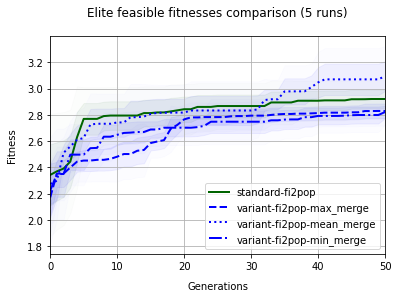

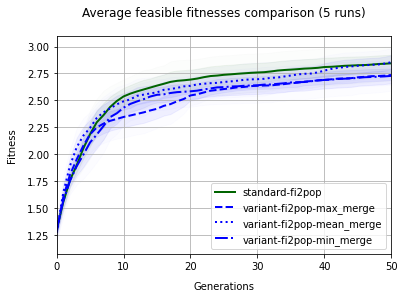

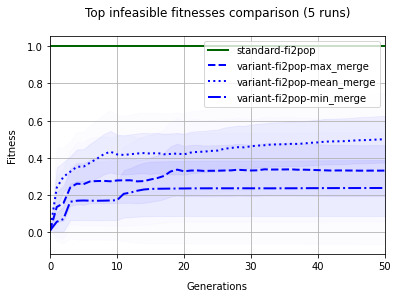

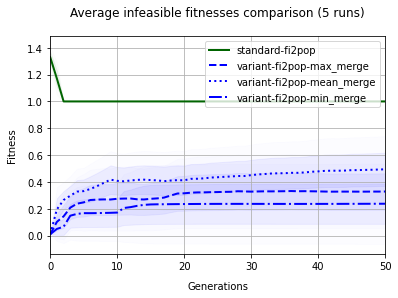

In [11]:
experiments = {'standard-fi2pop': {}, 
               'variant-fi2pop-max_merge': {},
               'variant-fi2pop-mean_merge': {},
               'variant-fi2pop-min_merge': {}
}

for experiment in experiments.keys():
    with open(f'results/{experiment}_metrics.npz', 'rb') as f:
        npzfile = np.load(f)
        experiments[experiment]['feasible'] = npzfile['arr_0']
        experiments[experiment]['infeasible'] = npzfile['arr_1']

feas_arrs = []
infeas_arrs = []
labels = []
for experiment in experiments.keys():
    feas_arrs.append(experiments[experiment]['feasible'])
    infeas_arrs.append(experiments[experiment]['infeasible'])
    labels.append(experiment)
colors = ['darkgreen', 'blue', 'blue', 'blue']
linestyles = ['solid', 'dashed', 'dotted', 'dashdot']

plot_compare(arrs=feas_arrs,
             colors=colors,
             linestyles=linestyles,
             labels=labels,
             title=f'Elite feasible fitnesses comparison ({N_RUNS} runs)',
             partial_filename='top-feas-fitness',
             plot_elites=True,
             add_area=True)

plot_compare(arrs=feas_arrs,
             colors=colors,
             linestyles=linestyles,
             labels=labels,
             title=f'Average feasible fitnesses comparison ({N_RUNS} runs)',
             partial_filename='avg-feas-fitness',
             plot_elites=False,
             add_area=True)

plot_compare(arrs=infeas_arrs,
             colors=colors,
             linestyles=linestyles,
             labels=labels,
             title=f'Top infeasible fitnesses comparison ({N_RUNS} runs)',
             partial_filename='top-infeas-fitness',
             plot_elites=True,
             add_area=True,
             legend_loc='upper right')

plot_compare(arrs=infeas_arrs,
             colors=colors,
             linestyles=linestyles,
             labels=labels,
             title=f'Average infeasible fitnesses comparison ({N_RUNS} runs)',
             partial_filename='avg-infeas-fitness',
             plot_elites=False,
             add_area=True,
             legend_loc='upper right')